In [1]:
from __future__ import print_function
%matplotlib inline

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cv2
import numpy as np
import math

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

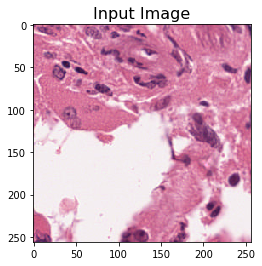

In [2]:
inputImageFile =('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


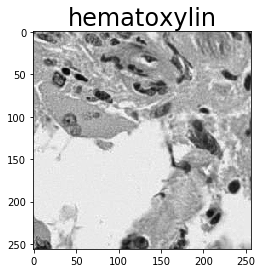

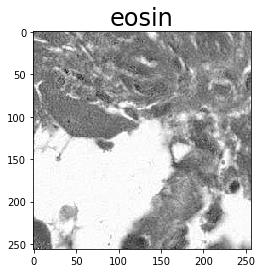

In [3]:
# create stain to color map using HistomicsTK
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

In [4]:
# Calculating Purple, Pink, White Pixels' - x,y co-ordinates
# Purple pixel:Cell Nuclie Material, 
# Pink Pixel:Stroma, Stomal cells’ cytoplasams, mucin-poor epithelial cells’s cytoplasms
# White pixels - Lumina, mucin-rich epithelial cells’s cytoplasms
def pixel_obj_gen(img_shape,imDecon_stains):  
    # Calculating hematoxylin average
    h_avg = np.average(imDecon_stains.Stains[:, :, 0])

    # Calculating Eosin average
    e_avg = np.average(imDecon_stains.Stains[:, :, 1])
    
    purple_pixel = []
    pink_pixel = []
    white_pixel = []
    purple_x = []
    purple_y = []
    pink_x = []
    pink_y = []
    white_x = []
    white_y = []
    for i in range(0,img_shape[0]):
          for j in range(0,img_shape[1]):
              h_p = imDecon_stains.Stains[i,j,0]
              e_p = imDecon_stains.Stains[i,j,1]
              if h_p <= h_avg: purple_pixel.append([i,j,h_p,e_p]),purple_x.append([i]),purple_y.append([j])
              if (h_p > h_avg and e_p <= e_avg): pink_pixel.append([i,j,h_p,e_p]),pink_x.append([i]),pink_y.append([j])
              if (h_p > h_avg and e_p > e_avg): white_pixel.append([i,j,h_p,e_p]),white_x.append([i]),white_y.append([j])
    return purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y

In [5]:
def circle_fit(x_coords,y_coords,pixel_len):
    # Pre-processing for Circle Fitting Algorithm for Histological objects
    x1 = np.array(x_coords) # Array of x-coordinates 
    y1 = np.array(y_coords) # Array of y-coordinates

    # Apply transformation on x,y co-ordinates
    x2 = x1.reshape(1, pixel_len)
    y2 = y1.reshape(1, pixel_len)

    # Mean value of x co-ordinate of Pink pixels
    sum_x=0
    for i in range(pixel_len):
        sum_x=sum_x+x2[0,i]
    x_mean=sum_x/(pixel_len -1)

    # Mean value of y co-ordinate of Pink Pixels
    sum_y=0
    for i in range(pixel_len):
        sum_y=sum_y+y2[0,i]
    y_mean=sum_y/(pixel_len - 1)
    
    # Circle Fitting Algorithm using linear algebra    
    u=[]
    v=[]
    Suv  = 0
    Suu  = 0
    Svv  = 0
    Suuv = 0
    Suvv = 0
    Suuu = 0
    Svvv = 0

    # calculation of the reduced coordinates
    for i in range(pixel_len):
            u.append((x2[0,i] - x_mean))
            v.append((y2[0,i] - y_mean))

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    for i in range(pixel_len):
        Suv  = Suv + (u[i]*v[i])
        Suu  = Suu+(u[i]*u[i])
        Svv  = Svv+(v[i]*v[i])
        Suuv = Suuv+(u[i]*u[i]*v[i])
        Suvv = Suvv+(u[i]* v[i]**2)
        Suuu = Suuu+(u[i]**3)
        Svvv = Svvv+(v[i]**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc_1 = x_mean + uc
    yc_1 = y_mean + vc

    # Calcuating Radius
    alpha = uc**2 + vc**2 +((Suu+Svv)/(pixel_len - 1))
    radius=math.sqrt(alpha)
    
    return xc_1,yc_1,radius 

In [6]:
img_shape = imInput.shape
imDecon_stains = imDeconvolved
purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y = pixel_obj_gen(img_shape,imDecon_stains)

In [ ]:
# Purple pixel Circle generation
purple_pixel_len=len(purple_pixel)
purple_xc_1, purple_yc_1, purple_radius = circle_fit(purple_x, purple_y, purple_pixel_len)

cv2.circle(imInput,(int(round(purple_xc_1)),int(round(purple_yc_1))),int(round(purple_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/purple_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/purple_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Pink pixel Circle generation
pink_pixel_len=len(pink_pixel)
pink_xc_1, pink_yc_1, pink_radius = circle_fit(pink_x, pink_y, pink_pixel_len)

cv2.circle(imInput,(int(round(pink_xc_1)),int(round(pink_yc_1))),int(round(pink_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/pink_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/pink_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

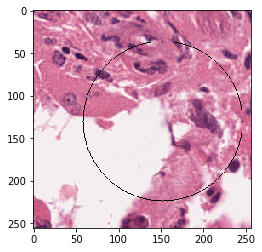

In [7]:
# White pixel Circle generation
white_pixel_len=len(white_pixel)
white_xc_1, white_yc_1, white_radius = circle_fit(white_x, white_y, white_pixel_len)

cv2.circle(imInput,(int(round(white_xc_1)),int(round(white_yc_1))),int(round(white_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/white_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/white_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()